In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import json
import os
import scipy.sparse

data_dir = 'data'

In [2]:
avg_diff = lambda a, b: np.absolute(a - b).mean()
def element_wise_diffs(q, diff=avg_diff, keys=None):
    diffs = {}
    
    for i in range(len(q)):
        for j in range(i + 1, len(q)):
            if keys is not None:
                key = (keys[i], keys[j])
            else:
                key = (i,j)
            diffs[key] = diff(q[i], q[j])
            
    return diffs

# Homework 2

## 1.3

### Load edges, nodes

In [3]:
edge_cols = ['Node1_id', 'Node2_id', 'Edge_weight', 'Edge_type', 'Source_id', 'Line_num']
edges = pd.read_csv('data/9606.hn_HS_CX.edge', sep='\t', names=edge_cols)

In [4]:
edges

,Node1_id,Node2_id,Edge_weight,Edge_type,Source_id,Line_num
0,ENSG00000284589,ENSG00000276821,0.000008,hn_HS_CX,humannet.HumanNet,248612
1,ENSG00000284589,ENSG00000267534,0.000006,hn_HS_CX,humannet.HumanNet,332085
2,ENSG00000284589,ENSG00000178802,0.000006,hn_HS_CX,humannet.HumanNet,318214
3,ENSG00000284589,ENSG00000172772,0.000007,hn_HS_CX,humannet.HumanNet,312029
4,ENSG00000284589,ENSG00000167751,0.000008,hn_HS_CX,humannet.HumanNet,243030
...,...,...,...,...,...,...
154382,ENSG00000000419,ENSG00000124802,0.000005,hn_HS_CX,humannet.HumanNet,394893
154383,ENSG00000000419,ENSG00000101557,0.000006,hn_HS_CX,humannet.HumanNet,360110
154384,ENSG00000000419,ENSG00000101224,0.000006,hn_HS_CX,humannet.HumanNet,328424
154385,ENSG00000000419,ENSG00000096401,0.000006,hn_HS_CX,humannet.HumanNet,321013


In [5]:
node_cols = ['Internal_id', 'Mapped_id', 'Node_type', 'Node_alias', 'Node_description']
node_map = pd.read_csv('data/9606.hn_HS_CX.node_map', sep='\t', names=node_cols)

In [6]:
node_map

,Internal_id,Mapped_id,Node_type,Node_alias,Node_description
0,ENSG00000187555,ENSG00000187555,Gene,USP7,ubiquitin specific peptidase 7 [Source:HGNC Sy...
1,ENSG00000196431,ENSG00000196431,Gene,CRYBA4,crystallin beta A4 [Source:HGNC Symbol;Acc:HGN...
2,ENSG00000166889,ENSG00000166889,Gene,PATL1,"PAT1 homolog 1, processing body mRNA decay fac..."
3,ENSG00000119042,ENSG00000119042,Gene,SATB2,SATB homeobox 2 [Source:HGNC Symbol;Acc:HGNC:2...
4,ENSG00000183508,ENSG00000183508,Gene,FAM46C,family with sequence similarity 46 member C [S...
...,...,...,...,...,...
10933,ENSG00000116903,ENSG00000116903,Gene,EXOC8,exocyst complex component 8 [Source:HGNC Symbo...
10934,ENSG00000047346,ENSG00000047346,Gene,FAM214A,family with sequence similarity 214 member A [...
10935,ENSG00000134901,ENSG00000134901,Gene,KDELC1,KDEL motif containing 1 [Source:HGNC Symbol;Ac...
10936,ENSG00000160180,ENSG00000160180,Gene,TFF3,trefoil factor 3 [Source:HGNC Symbol;Acc:HGNC:...


In [7]:
# check to see that all nodes are in 
node_map.Internal_id.equals(node_map.Mapped_id)

True

In [8]:
node_map.Internal_id.unique().shape

(10938,)

### Construct Matrices 
Construct Adjacency Matrix

In [9]:
nodes = node_map.Internal_id.unique()
adj = np.zeros((len(nodes), len(nodes)), dtype=float)

# dict stores indices for each node id
node_idx = dict(zip(nodes, range(len(nodes))))

In [10]:
duplicates = 0
for Node1_id, Node2_id, Edge_weight in zip(edges.Node1_id, edges.Node2_id, edges.Edge_weight):
    idx1 = node_idx[Node1_id]
    idx2 = node_idx[Node2_id]
    
    if (adj[idx1, idx2] == 0.0) and (adj[idx2, idx1] == 0.0):
        adj[idx1, idx2] = Edge_weight
        adj[idx2, idx1] = Edge_weight
    elif (adj[idx1, idx2] != Edge_weight) or (adj[idx2, idx1] != Edge_weight):
        print(f'Different duplicates in adjacency matrix: Nodes {Node1_id}, {Node2_id}')
        break
    else:
        duplicates +=1

# convert to sparse format
adj = scipy.sparse.csr_matrix(adj)
duplicates
    

0

In [11]:
adj.sum()

1.99998388988

In [12]:
adj.todense().size

119639844

Set self edges to 0

In [13]:
adj.setdiag(0.0)

/home/wma/miniconda3/envs/HW2tf2/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [14]:
adj.sum()

1.99996777668

Remove disconnected elements

In [15]:
disconnected = adj.sum(axis=1) <= 1e-6
disconnected.sum()

0

There are no disconnected elements!

Make a transition matrix by normalizing rows to 1:

In [16]:
trans = adj/adj.toarray().sum(axis=1,keepdims=1)
# convert to sparse
trans = scipy.sparse.csr_matrix(trans)

Save matrices and keys

In [17]:
scipy.sparse.save_npz(os.path.join(data_dir, 'adj.npz'), adj)
scipy.sparse.save_npz(os.path.join(data_dir, 'trans.npz'), trans)

with open(os.path.join(data_dir, 'nodes.txt'), 'w') as f:
    f.writelines("%s\n" % node for node in nodes)

with open(os.path.join(data_dir, 'node_idx.json'), 'w') as f:
    json.dump(node_idx, f)

### Random-Walk

In [18]:
adj = scipy.sparse.load_npz(os.path.join(data_dir, 'adj.npz'))
trans = scipy.sparse.load_npz(os.path.join(data_dir, 'trans.npz'))
        
nodes = []        
with open(os.path.join(data_dir, 'nodes.txt'), 'r') as f:
    nodes = [node.rstrip() for node in f.readlines()]

with open(os.path.join(data_dir, 'node_idx.json'), 'r') as f:
    node_idx = json.load(f)

Generate 3 random 1 hot vectors

In [19]:
# 3 random numbers
ones = np.random.default_rng(seed=27).integers(len(nodes), size=3)
# 1-hot them
qs = np.zeros((ones.size, len(nodes)))
qs[np.arange(ones.size),ones] = 1.0

Run q_(k+1) =q_k*P until convergence

In [20]:
# convert from sparse to dense
trans = trans.toarray()
converge_thresh = 1e-6 / len(nodes)                   
max_diff = lambda a, b: np.absolute(a - b).max()
                   
for i in range(len(qs)):    
    q_old = np.zeros(len(nodes))
    while max_diff(q_old, qs[i]) > converge_thresh:
        q_old = qs[i].copy()
        qs[i] = np.matmul(qs[i],trans)

In [21]:
qs

array([[1.04823342e-04, 1.18121578e-05, 7.41092327e-05, ...,
        1.28720406e-05, 4.46601784e-05, 3.23755836e-04],
       [1.04823342e-04, 1.18121578e-05, 7.41092327e-05, ...,
        1.28720406e-05, 4.46601784e-05, 3.23755836e-04],
       [1.04823342e-04, 1.18121578e-05, 7.41092327e-05, ...,
        1.28720406e-05, 4.46601784e-05, 3.23755837e-04]])

In [22]:
qs.sum(axis=1)

array([1., 1., 1.])

Confirm differences (maximum pair-wise element-wise absolute differences)

In [23]:
element_wise_diffs(qs, max_diff)

{(0, 1): 4.219634459350801e-11,
 (0, 2): 7.01661072214472e-11,
 (1, 2): 9.095610131193974e-11}

## 1.4

In [24]:
adj = scipy.sparse.load_npz(os.path.join(data_dir, 'adj.npz'))
trans = scipy.sparse.load_npz(os.path.join(data_dir, 'trans.npz'))
        
nodes = []        
with open(os.path.join(data_dir, 'nodes.txt'), 'r') as f:
    nodes = [node.rstrip() for node in f.readlines()]

with open(os.path.join(data_dir, 'node_idx.json'), 'r') as f:
    node_idx = json.load(f)
    


Generate 3 random 1 hot vectors

In [25]:
# 3 random numbers
ones = np.random.default_rng(seed=27).integers(len(nodes), size=3)
# 1-hot them
q0 = np.zeros((ones.size, len(nodes)))
q0[np.arange(ones.size),ones] = 1.0

In [26]:
# transition probs
p = [0.2, 0.5, 0.8]

# load first row as N1 and N2
edge_cols = ['Node1_id', 'Node2_id', 'Edge_weight', 'Edge_type', 'Source_id', 'Line_num']
edges = pd.read_csv('data/9606.hn_HS_CX.edge', sep='\t', names=edge_cols)

Ns = edges.iloc[0,:2].values
N_idx = [node_idx[N] for N in Ns]
v = np.zeros(((len(N_idx), len(nodes))))
v[np.arange(len(N_idx)),N_idx] = 1.0

In [27]:
v.argmax(axis=1), Ns, N_idx

(array([9308, 8296]),
 array(['ENSG00000284589', 'ENSG00000276821'], dtype=object),
 [9308, 8296])

* Provide one file that shows the stationary distribution of RWR for each of these probabilities, with N1 as the restart set. How does the value of 𝑝 affect the results?
* Repeat this with different choices of 𝐪0. Does the result change for a fixed value of 𝑝?
* Repeat the analysis above with N2 and 𝑝 = 0.2, 0.5, 0.8. Provide one file that shows the stationary distribution of RWR for each of these probabilities. How does the value of 𝑝 affect the results?

In [28]:
# convert from sparse to dense
trans = trans.toarray()
converge_thresh = 1e-6 / len(nodes)                   
max_diff = lambda a, b: np.absolute(a - b).max()

# shape is (# of v values, # of p values, # of q0 values, length of vectors)
qs_n1 = np.stack([q0.copy(), q0.copy(), q0.copy()])
qs_n = np.stack([qs_n1.copy(), qs_n1.copy()])

for i in range(len(v)):
    for j in range(len(p)):
        for k in range(len(q0)):
            q_old = np.zeros(len(nodes))
            while max_diff(q_old, qs_n[i,j,k]) > converge_thresh:
                q_old = qs_n[i,j,k].copy()
                # v[0] is n1, v[1] is n2
                qs_n[i,j,k] = p[j]*np.matmul(qs_n[i,j,k],trans) + (1 - p[j]) * v[i]

In [29]:
np.save(os.path.join(data_dir, 'qs_n.npy'), qs_n, allow_pickle=False)

Check different probabilities, N1, fixed q0

Confirm differences (maximum pair-wise element-wise absolute differences)

In [30]:
element_wise_diffs(qs_n[0,:,0], avg_diff, keys=p)

{(0.2, 0.5): 5.357318953900834e-05,
 (0.2, 0.8): 0.00010724172417683091,
 (0.5, 0.8): 5.475113985613568e-05}

In [31]:
df_vary_p = pd.DataFrame(qs_n[0,:,0].T, columns=p, index=nodes)
df_vary_p.index.name = 'genes|p'
df_vary_p.describe()

,0.2,0.5,0.8
count,1.093800e+04,1.093800e+04,10938.000000
mean,9.142439e-05,9.142439e-05,0.000091
std,7.672849e-03,4.922449e-03,0.002234
min,0.000000e+00,0.000000e+00,0.000000
25%,2.197092e-09,1.463258e-07,0.000002
50%,1.771513e-08,7.321868e-07,0.000007
75%,1.367469e-07,3.425074e-06,0.000026
max,8.016424e-01,5.086507e-01,0.215137


In [32]:
df_vary_p.sum()

0.2    1.0
0.5    1.0
0.8    1.0
dtype: float64

In [33]:
df_vary_p.to_csv(os.path.join(data_dir, "stat_dist_vary_p.csv"))

Check different q0, N1, p =0.2 fixed q0

Confirm differences (maximum pair-wise element-wise absolute differences)

In [34]:
element_wise_diffs(qs_n[0,0,:], avg_diff, keys=[nodes[one] for one in ones])

{('ENSG00000109689', 'ENSG00000162595'): 1.9079781774177728e-14,
 ('ENSG00000109689', 'ENSG00000116133'): 4.4811299993297143e-14,
 ('ENSG00000162595', 'ENSG00000116133'): 3.941233494687752e-14}

In [35]:
df_vary_q = pd.DataFrame(qs_n[0,0,:].T, columns=[nodes[one] for one in ones], index=nodes)
df_vary_q.index.name = 'genes|q0'
df_vary_q.describe()

,ENSG00000109689,ENSG00000162595,ENSG00000116133
count,1.093800e+04,1.093800e+04,1.093800e+04
mean,9.142439e-05,9.142439e-05,9.142439e-05
std,7.672849e-03,7.672849e-03,7.672849e-03
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.197092e-09,2.197088e-09,2.197086e-09
50%,1.771513e-08,1.771512e-08,1.771511e-08
75%,1.367469e-07,1.367469e-07,1.367469e-07
max,8.016424e-01,8.016424e-01,8.016424e-01


In [36]:
df_vary_q.sum()

ENSG00000109689    1.0
ENSG00000162595    1.0
ENSG00000116133    1.0
dtype: float64

In [37]:
df_vary_q.to_csv(os.path.join(data_dir, "stat_dist_vary_q.csv"))

Check different probabilities, N2, fixed q0

Confirm differences (maximum pair-wise element-wise absolute differences)

In [38]:
element_wise_diffs(qs_n[1,:,0], avg_diff, keys=p)

{(0.2, 0.5): 5.355597404743699e-05,
 (0.2, 0.8): 0.0001074546361017139,
 (0.5, 0.8): 5.696541272425046e-05}

In [39]:
df_vary_p_n2 = pd.DataFrame(qs_n[1,:,0].T, columns=p, index=nodes)
df_vary_p_n2.index.name = 'genes|p'
df_vary_p_n2.describe()

,0.2,0.5,0.8
count,1.093800e+04,1.093800e+04,10938.000000
mean,9.142439e-05,9.142439e-05,0.000091
std,7.674552e-03,4.921736e-03,0.002198
min,0.000000e+00,0.000000e+00,0.000000
25%,2.959191e-09,1.784808e-07,0.000002
50%,2.468543e-08,9.094516e-07,0.000008
75%,1.769539e-07,4.090109e-06,0.000029
max,8.017805e-01,5.088829e-01,0.214111


In [40]:
df_vary_p_n2.sum()

0.2    1.0
0.5    1.0
0.8    1.0
dtype: float64

In [41]:
df_vary_p_n2.to_csv(os.path.join(data_dir, "stat_dist_vary_p_n2.csv"))

Check N2 vs N1, p=0.2, fixed q0

Confirm differences (maximum pair-wise element-wise absolute differences)

In [42]:
element_wise_diffs(qs_n[:,0,0], avg_diff, keys=['N1', 'N2'])

{('N1', 'N2'): 0.0001518684150009106}

In [43]:
df_vary_v = pd.DataFrame(qs_n[:,0,0].T, columns=['N1', 'N2'], index=nodes)
df_vary_v.index.name = 'genes|v'
df_vary_v.describe()

,N1,N2
count,1.093800e+04,1.093800e+04
mean,9.142439e-05,9.142439e-05
std,7.672849e-03,7.674552e-03
min,0.000000e+00,0.000000e+00
25%,2.197092e-09,2.959191e-09
50%,1.771513e-08,2.468543e-08
75%,1.367469e-07,1.769539e-07
max,8.016424e-01,8.017805e-01


In [44]:
df_vary_v.sum()

N1    1.0
N2    1.0
dtype: float64

In [45]:
df_vary_v.to_csv(os.path.join(data_dir, "stat_dist_vary_v.csv"))

## 3

I basically used the tensorflow MNIST tutorial as a guide:
https://www.tensorflow.org/tutorials/quickstart/advanced

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation #, LeakyReLU
from tensorflow.keras import Model

TensorFlow version: 2.4.1


Load MNIST dataset

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# scale to 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [5]:
x_train.shape

(60000, 28, 28)

Define parameters for each model:

In [6]:
n_layers = [50, 20, 10, 5]
acts = [tf.nn.leaky_relu, tf.nn.leaky_relu, tf.nn.sigmoid, tf.nn.sigmoid]
n_nodes = 64
dropout = 0.2
lr = 0.001

models = []
optimizers = []
for i in range(len(n_layers)):
    models.append(tf.keras.Sequential())
    models[i].add(Flatten(input_shape=(28,28)))
    
    for j in range(n_layers[i]):
        models[i].add(Dense(n_nodes,
                            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=i*j+i)))
        models[i].add(BatchNormalization(epsilon=1e-06, momentum=0.9))
        models[i].add(Activation(acts[i]))
        models[i].add(Dropout(dropout))
    
    # return logits
    models[i].add(Dense(10, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=711)))
    models[i].add(BatchNormalization(epsilon=1e-06, momentum=0.9))
    
    optimizers.append(tf.keras.optimizers.Adam(learning_rate=lr))

In [7]:
models[3].summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 64)                50240     
_________________________________________________________________
batch_normalization_83 (Batc (None, 64)                256       
_________________________________________________________________
activation_80 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_84 (Dense)             (None, 64)                4160      
_________________________________________________________________
batch_normalization_84 (Batc (None, 64)               

In [8]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
batch_size = 32

histories = []
for i in range(len(models)):
    
    models[i].compile(optimizer=optimizers[i],
                      loss=loss_fn,
                      metrics=['accuracy'])
    
    print(f'Training model {i+1}')
    
    histories.append(models[i].fit(x_train,
                      y_train,
                      # using test set as validation set
                      validation_data=(x_test, y_test),
                      batch_size=batch_size,
                      epochs=5))

Training model 1
Epoch 1/5
1875/1875 [==============================] - 58s 28ms/step - loss: 2.4006 - accuracy: 0.1002 - val_loss: 2.3012 - val_accuracy: 0.1135
Epoch 2/5
1875/1875 [==============================] - 55s 29ms/step - loss: 2.3028 - accuracy: 0.1132 - val_loss: 2.3019 - val_accuracy: 0.1135
Epoch 3/5
1875/1875 [==============================] - 52s 28ms/step - loss: 2.2823 - accuracy: 0.1358 - val_loss: 2.2625 - val_accuracy: 0.1461
Epoch 4/5
1875/1875 [==============================] - 53s 28ms/step - loss: 2.1761 - accuracy: 0.1842 - val_loss: 2.0317 - val_accuracy: 0.2256
Epoch 5/5
1875/1875 [==============================] - 53s 28ms/step - loss: 2.0499 - accuracy: 0.2189 - val_loss: 1.9527 - val_accuracy: 0.2630
Training model 2
Epoch 1/5
1875/1875 [==============================] - 26s 13ms/step - loss: 2.2948 - accuracy: 0.1642 - val_loss: 1.3081 - val_accuracy: 0.6020
Epoch 2/5
1875/1875 [==============================] - 24s 13ms/step - loss: 1.3724 - accuracy: 

Plot

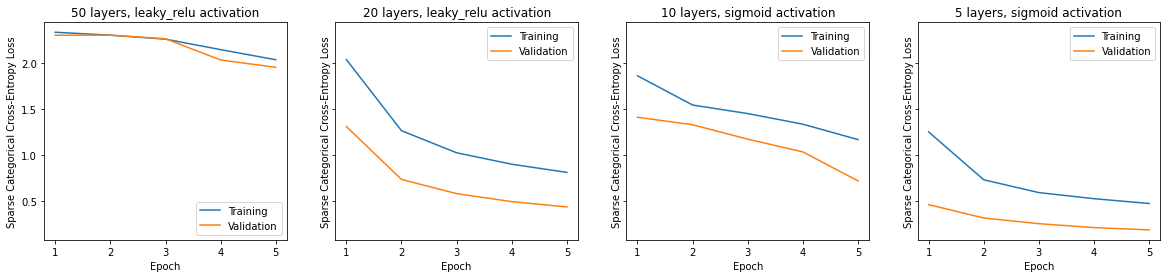

In [44]:
fig, axs = plt.subplots(1,4, figsize=(20,4), sharey=True)

for i, ax in enumerate(axs.flat):
    ax.plot(range(1,len(histories[i].history['loss'])+1),
            histories[i].history['loss'],
            label='Training')
    ax.plot(range(1,len(histories[i].history['val_loss'])+1),
            histories[i].history['val_loss'],
            label='Validation')
    ax.set_title(f'{n_layers[i]} layers, {acts[i].__name__} activation')
    ax.set_xlabel('Epoch')
    ax.legend(loc="upper right")
    ax.set_ylabel('Sparse Categorical Cross-Entropy Loss')
    
axs[0].legend(loc="lower right")

plt.show()